In [1]:
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, UpSampling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
# from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

# loading the weights just to get the latent_size
weights_dense = np.load("/home/niaki/Projects/learned-brief/weights/weights_dense_64.npy")
latent_size = weights_dense.shape[1]

In [3]:
base_dir = '/scratch/jurkat_ifc/ch3_dataset'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 56x56
        patches_out -- tensor of the original patches center cropped to 48x48 
                       and then downsampled to 24x24
    
    """
    files_patches = listdir(dir_patches)
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_orig = imageio.imread(dir_patches + '/' + file_patch)
        patch_in = np.zeros((input_patch_size, input_patch_size))
        patch_in[: 55, : 55] = patch_orig
        patch_in[55, :] = patch_in[54, :]
        patch_in[:, 55] = patch_in[:, 54]
         
        patch_out = patch_in[5: 53, 5: 53]  # center-crop to 48x48 (original BRIEF input patch size)
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    patches_in = np.expand_dims(patches_in, -1)
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    patches_out = np.expand_dims(patches_out, -1)
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (25809, 56, 56, 1) ; out (25809, 24, 24, 1)
in (3227, 56, 56, 1) ; out (3227, 24, 24, 1)


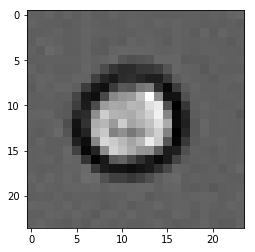

In [6]:
plt.imshow(np.array(y_validation[25, :, :, 0] * 255, dtype=np.uint8), cmap='gray')

In [7]:
image_datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.01,
    width_shift_range=0.01, height_shift_range=0.01, shear_range=0.01,
    horizontal_flip=False, fill_mode="nearest")

In [8]:
input_shape = (input_patch_size, input_patch_size, 1)

# encoder
input_img = Input(shape=input_shape)
x = Conv2D(1, (3,3), activation="relu", padding="valid")(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(latent_size, activation="sigmoid")(flattened)

# decoder
x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

# brief_ae = load_model('/home/niaki/Projects/learned-brief/weights_pub/learned_brief_ae_20200605.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [9]:
model_version = '0.0.0.3_randominit_output24X24_nodataaugm'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(image_datagen.flow(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_step4_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
25809/25809 [==============================] - 1067s 41ms/step - loss: 0.6360 - val_loss: 0.6359
Epoch 2/50
25809/25809 [==============================] - 1079s 42ms/step - loss: 0.6294 - val_loss: 0.6356
Epoch 3/50
25809/25809 [==============================] - 1089s 42ms/step - loss: 0.6291 - val_loss: 0.6406
Epoch 4/50
25809/25809 [==============================] - 1081s 42ms/step - loss: 0.6289 - val_loss: 0.6206
Epoch 5/50
25809/25809 [==============================] - 1085s 42ms/step - loss: 0.6288 - val_loss: 0.6275
Epoch 6/50
25809/25809 [==============================] - 1089s 42ms/step - loss: 0.6287 - val_loss: 0.6207
Epoch 7/50
25809/25809 [==============================] - 1095s 42ms/step - loss: 0.6286 - val_loss: 0.6239
Epoch 8/50
25809/25809 [==============================] - 1109s 43ms/step - loss: 0.6286 - val_loss: 0.6364
Epoch 9/50
25809/25809 [==============================] - 1112s 43ms/step - loss: 0.6285 - val_loss: 0.6250
Epoch 10/50
25809/25809 [===

In [10]:
history_callback.history

{'val_loss': [0.635900616645813,
  0.635583758354187,
  0.6405807733535767,
  0.6205508708953857,
  0.6274705529212952,
  0.6206982135772705,
  0.6238939166069031,
  0.6363809108734131,
  0.6250355839729309,
  0.630238950252533,
  0.6368017196655273,
  0.6267126798629761,
  0.6183999180793762,
  0.6335631012916565,
  0.6233062744140625,
  0.627411425113678,
  0.6333070993423462,
  0.6335926055908203,
  0.6372308731079102,
  0.6293246150016785,
  0.6239211559295654,
  0.6330633759498596,
  0.6248332262039185,
  0.627511739730835,
  0.6201408505439758,
  0.6211569905281067,
  0.6253113150596619,
  0.6247506141662598,
  0.629323422908783,
  0.6183432936668396,
  0.6286041736602783,
  0.6299655437469482,
  0.6282802224159241,
  0.625542938709259,
  0.6192855834960938,
  0.6262071132659912,
  0.6319566965103149,
  0.6328170299530029,
  0.6235807538032532,
  0.6317338943481445,
  0.6328347325325012,
  0.6236607432365417,
  0.607232928276062,
  0.6328568458557129,
  0.6272726655006409,
  0.63

In [11]:
input_shape = (input_patch_size, input_patch_size, 1)

original patch:


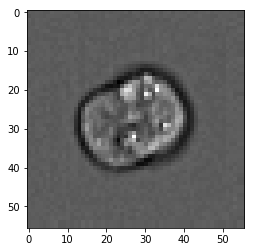

original patch center-cropped and downsampled:


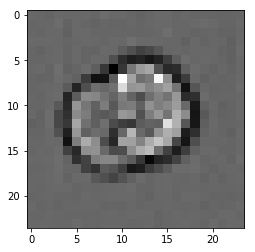

reconstructed patch from its BRIEF encoding:


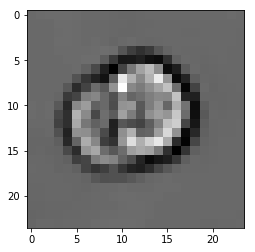

RMSE: 7.380365347489715

original patch:


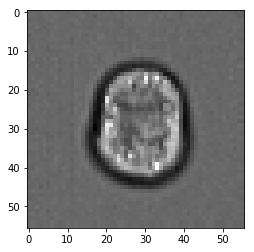

original patch center-cropped and downsampled:


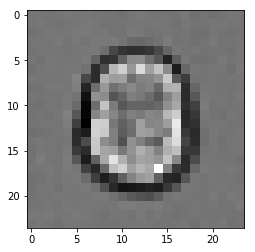

reconstructed patch from its BRIEF encoding:


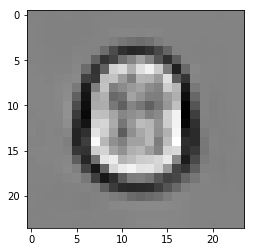

RMSE: 8.824745267629623

original patch:


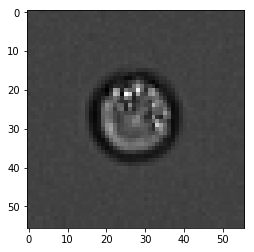

original patch center-cropped and downsampled:


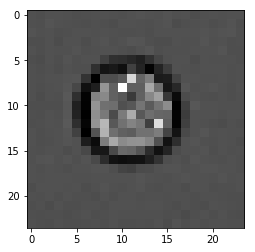

reconstructed patch from its BRIEF encoding:


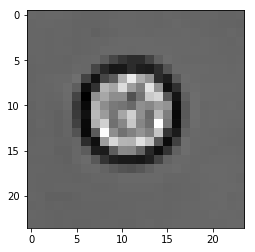

RMSE: 4.76699810475111

original patch:


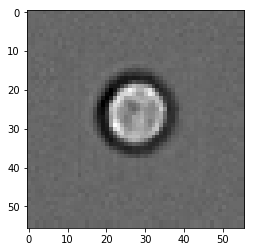

original patch center-cropped and downsampled:


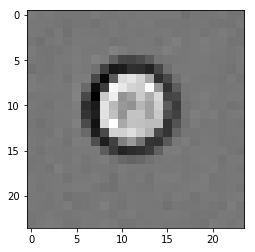

reconstructed patch from its BRIEF encoding:


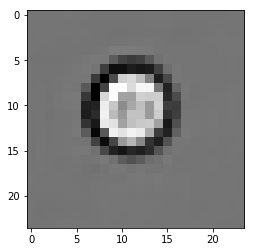

RMSE: 5.4118140041828156

original patch:


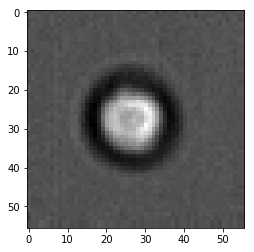

original patch center-cropped and downsampled:


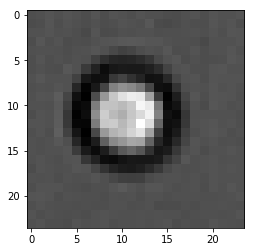

reconstructed patch from its BRIEF encoding:


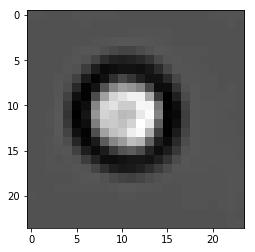

RMSE: 3.2426329515874386

original patch:


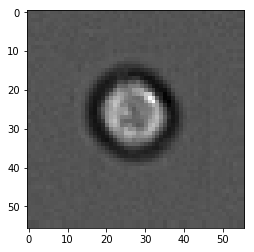

original patch center-cropped and downsampled:


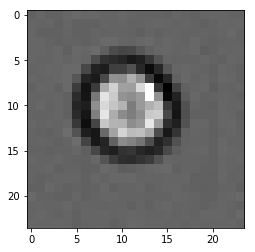

reconstructed patch from its BRIEF encoding:


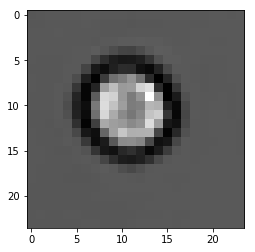

RMSE: 3.9420706825330853

original patch:


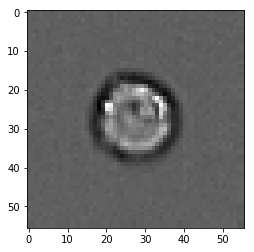

original patch center-cropped and downsampled:


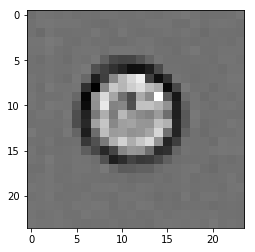

reconstructed patch from its BRIEF encoding:


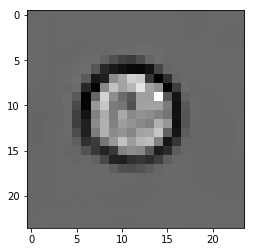

RMSE: 3.761020372621715

original patch:


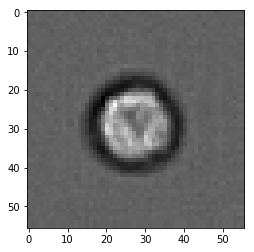

original patch center-cropped and downsampled:


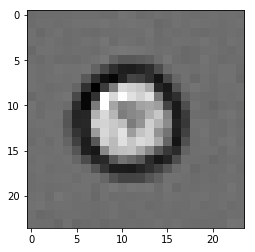

reconstructed patch from its BRIEF encoding:


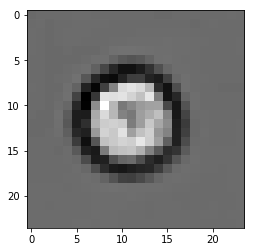

RMSE: 3.661704151891172

original patch:


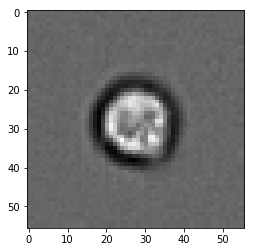

original patch center-cropped and downsampled:


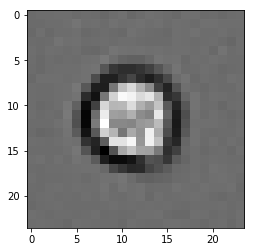

reconstructed patch from its BRIEF encoding:


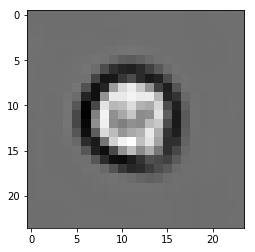

RMSE: 5.17439846880734

original patch:


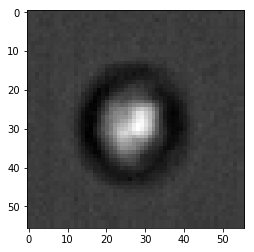

original patch center-cropped and downsampled:


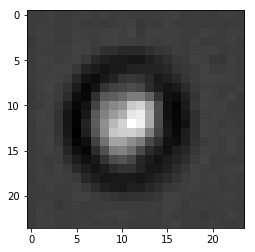

reconstructed patch from its BRIEF encoding:


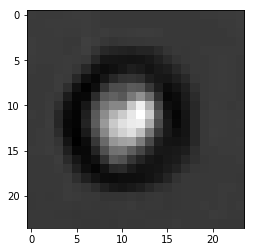

RMSE: 4.985263142734766

average RMSE 0.020059220585972072


In [12]:
# show some reconstructed patches

images_directory = base_dir + '/test'
files = os.listdir(images_directory)
files.sort()
files = files[: 10]

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
         
        temp_img = np.zeros((input_patch_size, input_patch_size))
        temp_img[: 55, : 55] = img
        temp_img[55, :] = temp_img[54, :]
        temp_img[:, 55] = temp_img[:, 54]
        
        img = np.expand_dims(temp_img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    print("original patch:")
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    print("original patch center-cropped and downsampled:")
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    print("reconstructed patch from its BRIEF encoding:")
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print("RMSE:", rmse * 255)
    rmses += rmse
    
    print("\n==============================================")
    
rmses /= len(images)
print("average RMSE", rmses)